# Driver Activity Recognition
Distracted driver detection and classification using traditional machine learning techniques and deep convolutional neural networks

In [ ]:
#importing files from kaggle dataset 
# kaggle link: https://www.kaggle.com/c/state-farm-distracted-driver-detection
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

#!pip uninstall -y kaggle
#!pip install --upgrade pip
#!pip install kaggle==1.5.6
#!kaggle -v

In [3]:
! kaggle competitions download -c 'state-farm-distracted-driver-detection' 

100% 4.00G/4.00G [01:33<00:00, 46.5MB/s]
100% 4.00G/4.00G [01:33<00:00, 45.8MB/s]


In [ ]:
  ! mkdir state-farm-data
  ! unzip state-farm-distracted-driver-detection.zip 

# Description:
This project aims to develop a machine learning model to detect and classify different distracted states of car drivers. 

Results of this project may be used for further research and applied to as a part of an on-car monitoring system where the machine will decide to take-over control of the car if the driver is distracted and poses a potential accident.

In [1]:
import cv2    
import pandas as pd                              
import numpy as np                                 
import os                                          
from keras.preprocessing import image              
import matplotlib.pyplot as plt   
import scipy
import glob

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import image
from keras import backend as K
from keras.optimizers import Adam

from keras.models import Model
from keras import applications
from keras.layers import GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical

import matplotlib
matplotlib.interactive(False)

import os
print(os.listdir("imgs"))

Using TensorFlow backend.


['train', 'test']


# Data

Data is a collection of 10 different states of drivers containing one safe driving and 9 other distracted modes.

c0: safe driving

c1: texting - right

c2: talking on the phone - right

c3: texting - left

c4: talking on the phone - left

c5: operating the radio

c6: drinking

c7: reaching behind

c8: hair and makeup

c9: talking to passenger

In [6]:
df_train = pd.read_csv('driver_imgs_list.csv')
print('Number of Samples in trainset : {}'.format(df_train.shape[0]))
print('Number Of districted Classes : {}'.format(len((df_train.classname).unique())))

Number of Samples in trainset : 22424
Number Of districted Classes : 10


# Visualisation

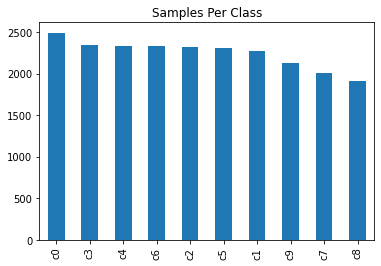

In [ ]:
freq = df_train.classname.value_counts()

freq.plot(kind='bar', label='index')
plt.title('Samples Per Class')
plt.show()

c0: safe driving


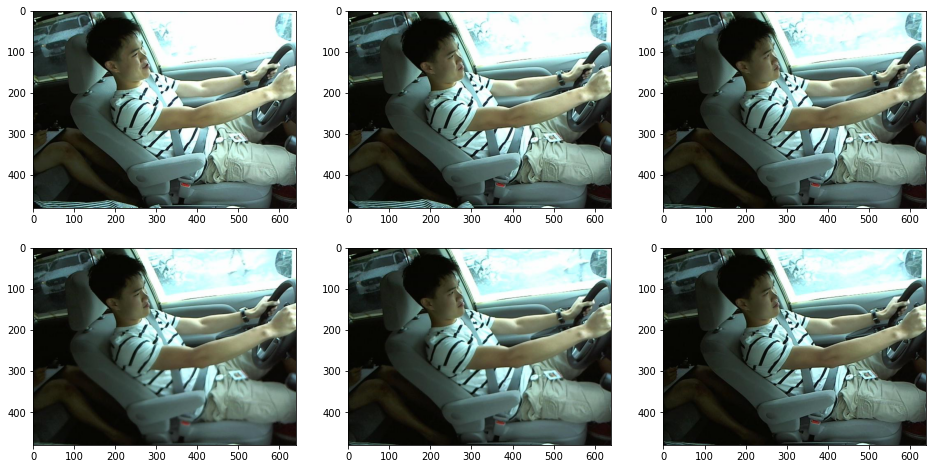

In [ ]:
from keras.preprocessing.image import load_img

def image(imgs, df, classId='c1'):
    fig, axis = plt.subplots(2, 3, figsize=(16, 8))
    for i, (idx, row) in enumerate(imgs.iterrows()):
        imgPath = os.path.join('imgs/train', f"{classId}/{row['img']}")
        r = i // 3
        c = i % 3 
        img = load_img(imgPath)
        plt.imshow(img)
        axis[r, c].imshow(img)
    plt.show()
    
print('c0: safe driving')
image(df_train[df_train.classname == 'c0'].head(6), df_train, classId='c0')

c1: texting - right


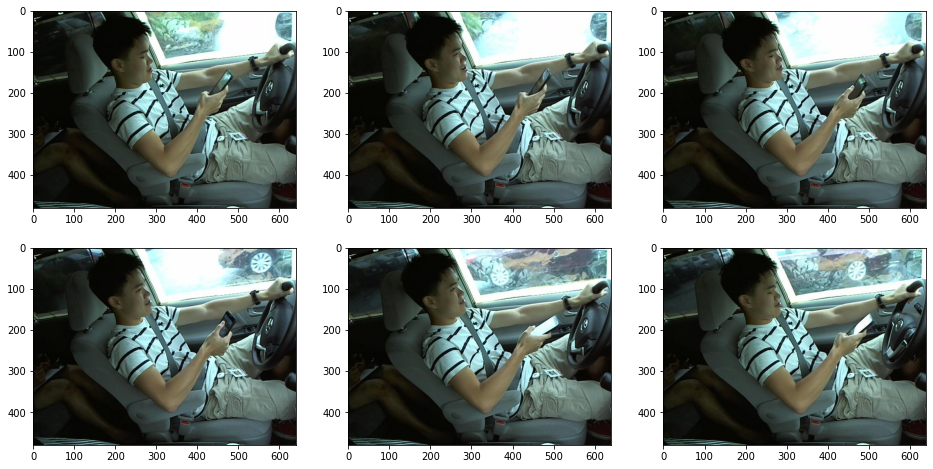

In [ ]:
print('c1: texting - right')
image(df_train[df_train.classname == 'c1'].head(6), df_train, classId='c1')

c2:  talking on the phone - right


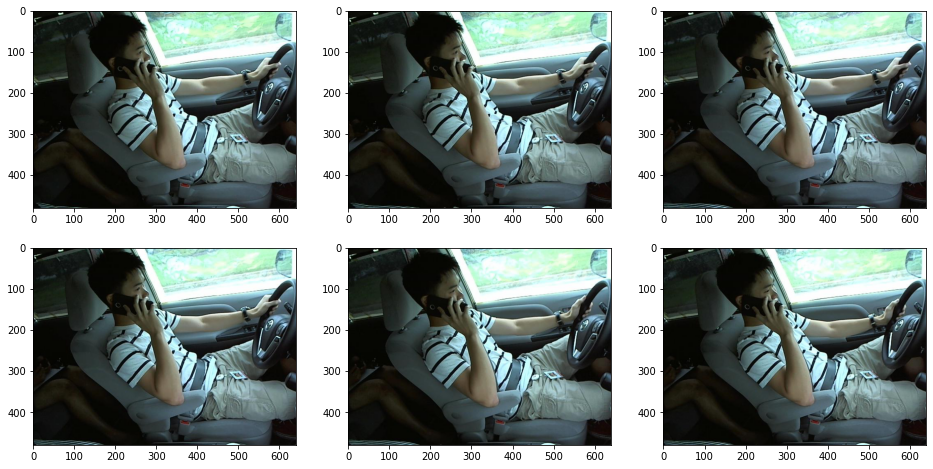

In [ ]:
print('c2:  talking on the phone - right')
image(df_train[df_train.classname == 'c2'].head(6), df_train, classId='c2')

c3: texting - left


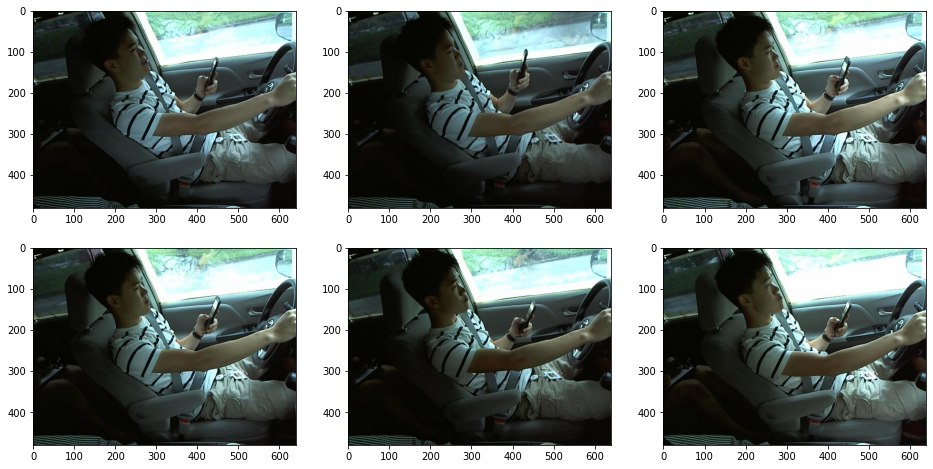

In [ ]:
print('c3: texting - left')
image(df_train[df_train.classname == 'c3'].head(6), df_train, classId='c3')

# Data directories

In [2]:
def resize(path, img_h, img_w):
    img = cv2.imread(path)
    resized = cv2.resize(img, (img_h, img_w))
    return resized

def create_data():
    TRAIN_DIR = 'imgs/train'
    train_images = [] 
    train_labels = []
    # Loop over the training folder 
    for i in range(10):
        print('Loading directory c{}'.format(i))
        files =glob.glob(os.path.join(TRAIN_DIR, 'c' + str(i), '*.jpg'))
        for file in files:
            img = resize(file, 128, 128)
            train_images.append(img)
            train_labels.append(i)
    return train_images, train_labels 

X_train, Y = create_data()

Loading directory c0
Loading directory c1
Loading directory c2
Loading directory c3
Loading directory c4
Loading directory c5
Loading directory c6
Loading directory c7
Loading directory c8
Loading directory c9


In [3]:
np_image_list = np.array(X_train, dtype=np.float16) / 225.0
label = np.asarray(Y)

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

img_size = len(X_train)
print(img_size) 

22424


# Splitting to test and validation sets

In [4]:
X_train,X_val,y_train,y_val=train_test_split(np_image_list,label,test_size=0.20,random_state=42)
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))

print("X_train shape",X_train.shape)
print("X_test shape",X_val.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_val.shape)

X_train shape (17939, 49152)
X_test shape (4485, 49152)
y_train shape (17939,)
y_test shape (4485,)


# Gaussian Naive Bayes Classifier

In [5]:
nb = GaussianNB()
nb_results = cross_val_score(nb, X_train, y_train, cv=KFold(n_splits=5) , scoring="accuracy")
print("Mean Accuracy: %f" % (nb_results.mean()))

Mean Accuracy: 0.550700


# Decision Tree Classifier

In [6]:
dt= DecisionTreeClassifier()
dt_results = cross_val_score(dt, X_train, y_train, cv=KFold(n_splits=5) , scoring="accuracy")
print("Mean Accuracy: %f" % (dt_results.mean()))

Mean Accuracy: 0.845420


# CNN Model

In [9]:
X_train,X_val,y_train,y_val=train_test_split(np_image_list,label,test_size=0.20,random_state=42)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

print("X_train shape",X_train.shape)
print("X_val shape",X_val.shape)
print("y_train shape",y_train.shape)
print("y_val shape",y_val.shape)

X_train shape (17939, 128, 128, 3)
X_val shape (4485, 128, 128, 3)
y_train shape (17939, 10)
y_val shape (4485, 10)


In [ ]:
CNN_simple = Sequential([
        BatchNormalization(input_shape=(128,128,3)),
    
        Conv2D(32,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((3,3)),
    
        Conv2D(64,(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((3,3)),
    
        Flatten(),
        Dense(200, activation='relu'),
    
        BatchNormalization(),
        Dense(10, activation='softmax')
    ])

CNN_simple.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])
CNN_simple.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_9 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_10 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
batch_normalization_11 (Batc (None, 40, 40, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 64)       

In [ ]:
batch_size=32
model_cnn = CNN_simple.fit(X_train,y_train, batch_size=batch_size, epochs=3,
                             validation_data =(X_val,y_val))

Train on 17939 samples, validate on 4485 samples
Epoch 1/3
17939/17939 [==============================] - 37s 2ms/step - loss: 0.3577 - accuracy: 0.9067 - val_loss: 0.1576 - val_accuracy: 0.9670
Epoch 2/3
17939/17939 [==============================] - 28s 2ms/step - loss: 0.0385 - accuracy: 0.9956 - val_loss: 0.0458 - val_accuracy: 0.9911
Epoch 3/3
17939/17939 [==============================] - 28s 2ms/step - loss: 0.0178 - accuracy: 0.9985 - val_loss: 0.0397 - val_accuracy: 0.9918


In [ ]:
scores = CNN_simple.evaluate(X_train,y_train)
print(f"Train Accuracy: {scores[1]*100}")
scores = CNN_simple.evaluate(X_val, y_val)
print(f"Test Accuracy: {scores[1]*100}")

17939/17939 [==============================] - 11s 620us/step
Train Accuracy: 99.74357485771179
4485/4485 [==============================] - 3s 611us/step
Test Accuracy: 99.17502999305725


We can observe that the model is clearly overfitting. Hence we will use data augmentation and dropout layers in the CNN model.

# Data Augmentation

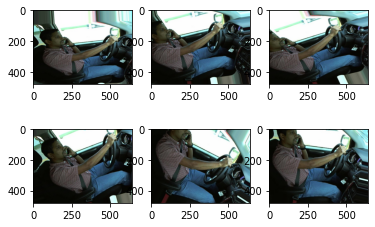

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

image=load_img(os.path.join('imgs/train/c4/img_57759.jpg'))
image=img_to_array(image)
image=np.expand_dims(image, axis=0)
generator = ImageDataGenerator(rotation_range=30, height_shift_range=0.1,
                               width_shift_range=0.1, shear_range=0.2, 
                               zoom_range=0.2, horizontal_flip=False,
                               fill_mode='nearest') 

imageGen=generator.flow(image,batch_size=1)

for i in range(6):
    nextImg=imageGen.next()
    plt.subplot(230 + 1 + i)
    image = nextImg[0].astype('uint8')
    plt.imshow(image)
plt.show()

In [11]:
aug = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

# CNN with dropouts 

In [12]:
default_image_size = tuple((128,128))
image_size = 0

width=128
height=128
depth=3
n_classes= 10

In [13]:
model = Sequential()
inputShape = (128,128,3)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (128,128,3)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(10))
model.add(Activation("softmax"))
model.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 42, 42, 64)       

In [14]:
bs = 32
history = model.fit_generator(
    aug.flow(X_train, y_train, batch_size=bs),
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) // bs,
    epochs=25, verbose=1
    )

Epoch 1/25
560/560 [==============================] - 109s 195ms/step - loss: 2.8705 - accuracy: 0.1895 - val_loss: 2.6133 - val_accuracy: 0.1991
Epoch 2/25
560/560 [==============================] - 102s 182ms/step - loss: 2.2223 - accuracy: 0.3038 - val_loss: 1.6058 - val_accuracy: 0.4845
Epoch 3/25
560/560 [==============================] - 102s 182ms/step - loss: 1.8500 - accuracy: 0.3987 - val_loss: 1.2405 - val_accuracy: 0.5795
Epoch 4/25
560/560 [==============================] - 102s 182ms/step - loss: 1.5498 - accuracy: 0.4827 - val_loss: 1.1077 - val_accuracy: 0.6401
Epoch 5/25
560/560 [==============================] - 102s 182ms/step - loss: 1.2880 - accuracy: 0.5628 - val_loss: 0.9214 - val_accuracy: 0.6896
Epoch 6/25
560/560 [==============================] - 102s 181ms/step - loss: 1.1040 - accuracy: 0.6274 - val_loss: 1.0315 - val_accuracy: 0.6774
Epoch 7/25
560/560 [==============================] - 102s 181ms/step - loss: 0.9537 - accuracy: 0.6744 - val_loss: 0.8972 -

In [15]:
scores = model.evaluate(X_train,y_train)
print(f"Train Accuracy: {scores[1]*100}")
scores = model.evaluate(X_val, y_val)
print(f"Test Accuracy: {scores[1]*100}")

17939/17939 [==============================] - 22s 1ms/step
Train Accuracy: 94.3419337272644
4485/4485 [==============================] - 5s 1ms/step
Test Accuracy: 94.33667659759521


In [ ]:
model.save('cnn_model.h5')

# Model Evaluation

In [16]:
# List all data in history
print(model.history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


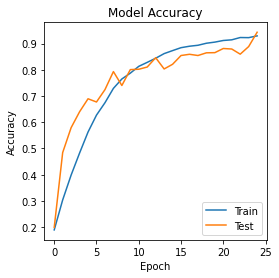

In [17]:
# Summarize history for accuracy
plt.figure(figsize=(4,4))
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

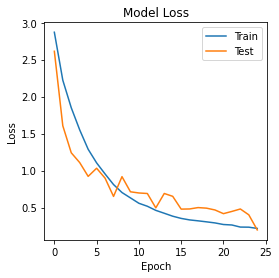

In [18]:
# Summarize history for loss
plt.figure(figsize=(4,4))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Conclusion 

We successfully implemented a Convolutional Neural Network model that has great performance on the distracted driver detection task and gives an evaluation accuracy of 94.337%

The Convolutional Neural Network has many advantages on image classification tasks compared to traditional machine learning techniques. 

For further improvement of these models, we could apply more sophisticated weight initialization methods or semi-supervised learning methods.

Finally, we could also try out some existing packages of more complex CNN-based models like ResNet or VGG.